In [86]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import myUtils
import EfficientNet
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import utils as utils
from GTSRB_utils import GTSRB_CLASSES, predict_traffic_sign, create_subset_loader
from uap_attack import generate_uap

In [3]:
# Direct download from original source (Institut für Neuroinformatik)
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip

# Unzip both files
!unzip GTSRB_Final_Training_Images.zip
!unzip GTSRB_Final_Test_Images.zip

# Cleanup (optional)
!rm *.zip

print("Dataset downloaded and extracted!")

Streaming output truncated to the last 5000 lines.
  inflating: GTSRB/Final_Test/Images/07633.ppm  
  inflating: GTSRB/Final_Test/Images/07634.ppm  
  inflating: GTSRB/Final_Test/Images/07635.ppm  
  inflating: GTSRB/Final_Test/Images/07636.ppm  
  inflating: GTSRB/Final_Test/Images/07637.ppm  
  inflating: GTSRB/Final_Test/Images/07638.ppm  
  inflating: GTSRB/Final_Test/Images/07639.ppm  
  inflating: GTSRB/Final_Test/Images/07640.ppm  
  inflating: GTSRB/Final_Test/Images/07641.ppm  
  inflating: GTSRB/Final_Test/Images/07642.ppm  
  inflating: GTSRB/Final_Test/Images/07643.ppm  
  inflating: GTSRB/Final_Test/Images/07644.ppm  
  inflating: GTSRB/Final_Test/Images/07645.ppm  
  inflating: GTSRB/Final_Test/Images/07646.ppm  
  inflating: GTSRB/Final_Test/Images/07647.ppm  
  inflating: GTSRB/Final_Test/Images/07648.ppm  
  inflating: GTSRB/Final_Test/Images/07649.ppm  
  inflating: GTSRB/Final_Test/Images/07650.ppm  
  inflating: GTSRB/Final_Test/Images/07651.ppm  
  inflating: GTSRB

In [30]:
data_dir = "GTSRB/Final_Training/Images"  # Path to training folder
test_dir = "GTSRB/Final_Test/Images"    # Path to testing folder
batch_size = 32
target_size = (240, 240)


# Define augmentation for training data
train_datagen = ImageDataGenerator(          # Normalize pixel values to [0, 1]
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=False,
    validation_split=0.2      # Reserve 20% for validation
)

# Generator for validation (no augmentation, same normalization)
val_datagen = ImageDataGenerator(           # Match training normalization
    validation_split=0.1
)

# Generator for testing (no augmentation, no split)
test_datagen = ImageDataGenerator(
    validation_split = 0.1
)

# Training generator (from training folder)
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="sparse",
    subset="training",
    seed=42
)



Found 31368 images belonging to 43 classes.


In [32]:
from tensorflow.keras.models import load_model
model = load_model("EfficientNetB1.keras")

In [67]:
train_subset_loader = create_subset_loader(train_generator, subset_fraction=0.02, batch_size=8)

Subset DataLoader: 627 samples


In [68]:
uap_delta = generate_uap(model, train_subset_loader, epsilon=10, num_epochs=10)

UAP Epoch [1/10] Avg Loss: -8.9752
Delta range: min=-10.0000, max=10.0000
UAP Epoch [2/10] Avg Loss: -20.3122
Delta range: min=-10.0000, max=10.0000
UAP Epoch [3/10] Avg Loss: -21.8915
Delta range: min=-10.0000, max=10.0000
UAP Epoch [4/10] Avg Loss: -22.5659
Delta range: min=-10.0000, max=10.0000
UAP Epoch [5/10] Avg Loss: -22.9579
Delta range: min=-10.0000, max=10.0000
UAP Epoch [6/10] Avg Loss: -23.2100
Delta range: min=-10.0000, max=10.0000
UAP Epoch [7/10] Avg Loss: -23.4161
Delta range: min=-10.0000, max=10.0000
UAP Epoch [8/10] Avg Loss: -23.5546
Delta range: min=-10.0000, max=10.0000
UAP Epoch [9/10] Avg Loss: -23.6548
Delta range: min=-10.0000, max=10.0000
UAP Epoch [10/10] Avg Loss: -23.7602
Delta range: min=-10.0000, max=10.0000


In [ ]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# prompt: move EfficientNetB1.keras to drive

import shutil

# Move the model file
shutil.move("EfficientNetB1.keras", "/content/drive/MyDrive/")


'/content/drive/MyDrive/EfficientNetB1.keras'

In [83]:
import numpy as np

np.save("uap_delta_ep10.npy", uap_delta)  # Convert to NumPy before saving


In [88]:
uap_delta_ep10 = np.load("uap_delta_ep10.npy")


In [39]:
from GTSRB_utils import load_ppm_image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction shape: (1, 43)
Predicted class: Speed limit 70


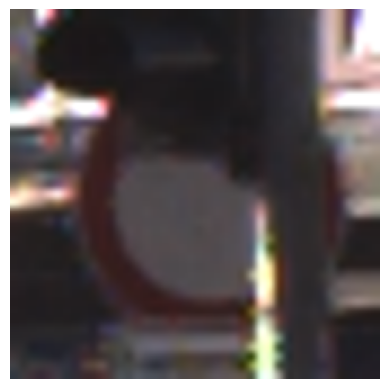

In [81]:
import tensorflow as tf
from PIL import Image
import numpy as np

# Path to your .ppm image
image_path = "/content/GTSRB/Final_Training/Images/00015/00000_00000.ppm"

# Load and preprocess the image with the correct target size (240x240)
image = load_ppm_image(image_path, target_size=(240, 240))
# Call your prediction function with the image, model, and class mapping
predict_traffic_sign(image, model, GTSRB_CLASSES)

plt.imshow(image[0].numpy().astype(np.uint8))
plt.axis('off')  # Hide axes for better visualization
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction shape: (1, 43)
Predicted class: Vehicles over 3.5 tons prohibited


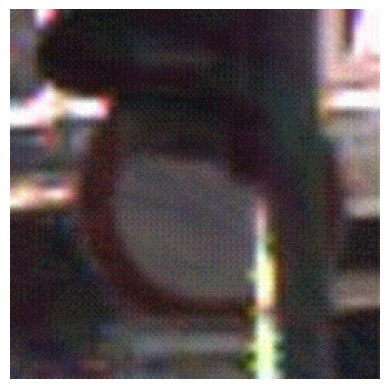

In [90]:
adv = image + uap_delta
adv = tf.clip_by_value(adv, 0, 255.0)

predict_traffic_sign(adv, model, GTSRB_CLASSES)

plt.imshow(adv[0].numpy().astype(np.uint8))
plt.axis('off')  # Hide axes for better visualization
plt.show()

In [85]:
import gdown
file_id = "1CqWWWXFpAd9vzVM8zdc4UwdAz_3d4pCn"
output = "testset_sample.zip"  # Adjust the output name based on the actual file format (e.g., .zip, .csv, .parquet, etc.)

gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

import zipfile
import os

with zipfile.ZipFile("testset_sample.zip", 'r') as zip_ref:
    zip_ref.extractall("testset")  # Extract to a folder named "dataset"

# Verify the extracted contents
os.listdir("testset")
import pandas as pd

# Load the CSV file
labels_df = pd.read_csv("testset/Attack_Test.csv")

# Display the first few rows to understand the structure
print(labels_df.head())

# Assuming the CSV has columns like 'filename' and 'label'
# Adjust column names based on the actual CSV structure
image_filenames = labels_df['Path'].values  # e.g., '12617.png'
labels = labels_df['ClassId'].values  # e.g., 0 or 1, or class names


import tensorflow as tf
import numpy as np

# Define image parameters
img_height = 240  # Adjust to match your model's expected input size
img_width = 240
batch_size = 32

# Function to load and preprocess images (using tf operations)
def load_and_preprocess_image(image_path):
    # Read the image file
    img = tf.io.read_file(image_path)  # image_path is already a tensor string
    img = tf.image.decode_png(img, channels=3)  # Assuming RGB images

    # Resize to target size
    img = tf.image.resize(img, [img_height, img_width])

    return img

# Create a dataset from the image filenames and labels
def create_dataset(image_filenames, labels):
    # Convert filenames and labels to tensors
    base_dir = "testset"
    image_paths = [os.path.join(base_dir, fname) for fname in image_filenames]
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    # Map the load_and_preprocess_image function
    dataset = dataset.map(
        lambda path, label: (load_and_preprocess_image(path), label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Shuffle, batch, and prefetch
    dataset = dataset.shuffle(buffer_size=len(image_filenames))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

# Create the dataset
dataset = create_dataset(image_filenames, labels)

Downloading...
From: https://drive.google.com/uc?id=1CqWWWXFpAd9vzVM8zdc4UwdAz_3d4pCn
To: /content/testset_sample.zip
100%|██████████| 3.54M/3.54M [00:00<00:00, 215MB/s]

   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId       Path
0     39      39       6       5      34      34        0  00243.png
1     39      40       5       5      34      35        0  00778.png
2     35      36       5       6      30      31        0  04726.png
3     49      51       6       5      44      46        0  06854.png
4     34      34       6       6      29      29        0  02045.png


In [87]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_true = []
y_pred = []

for batch_images, batch_labels in dataset:
    preds = model.predict(batch_images)
    pred_classes = tf.argmax(preds, axis=1).numpy()

    y_true.extend(batch_labels.numpy())
    y_pred.extend(pred_classes)

# Evaluate
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=GTSRB_CLASSES.values() if isinstance(GTSRB_CLASSES, dict) else class_mapping))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Accuracy: 0.9632

Classification Report:
                                              precision    recall  f1-score   support

                              Speed limit 20       1.00      1.00      1.00        12
                              Speed limit 30       1.00      1.00      1.00        12
                              Speed limit 50       1.00

In [91]:
import tensorflow as tf
import numpy as np
import os


uap_delta_ep10 = np.load("uap_delta_ep10.npy")

# --- parameters ---
img_height = 240
img_width  = 240
batch_size = 32
base_dir   = "testset"

def load_and_preprocess_with_uap(image_path, label):
    # 1) load & decode
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.cast(img, tf.float32)

    # 2) add the UAP delta
    adv = img + uap_delta_ep10

    # 3) clip to valid range [0,255]
    adv = tf.clip_by_value(adv, 0.0, 255.0)

    # 4) (optional) normalize to [0,1] or [-1,1] if your model expects that
    # adv = adv / 255.0

    return adv, label

def create_adv_dataset(image_filenames, labels):
    # build full paths
    image_paths = [os.path.join(base_dir, fname) for fname in image_filenames]

    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    ds = ds.map(load_and_preprocess_with_uap,
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(buffer_size=len(image_filenames))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# usage
adv_dataset = create_adv_dataset(image_filenames, labels)


In [93]:


y_true = []
y_pred = []

for batch_images, batch_labels in adv_dataset:
    preds = model.predict(batch_images)
    pred_classes = tf.argmax(preds, axis=1).numpy()

    y_true.extend(batch_labels.numpy())
    y_pred.extend(pred_classes)

# Evaluate
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=GTSRB_CLASSES.values() if isinstance(GTSRB_CLASSES, dict) else GTSRB_CLASSES
))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Accuracy: 0.3430

Classification Report:
                                              precision    recall  f1-score   support

                              Speed limit 20       1.00      0.17      0.29        12
                              Speed limit 30       1.00      0.83      0.91        12
                              Speed limi

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


some adversarial images:


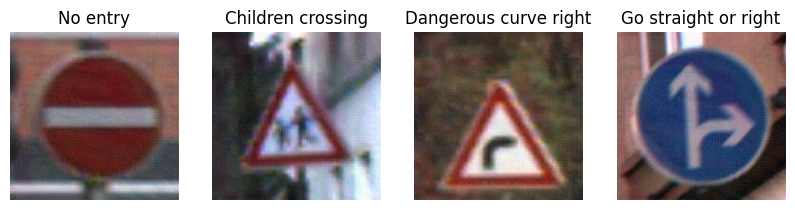

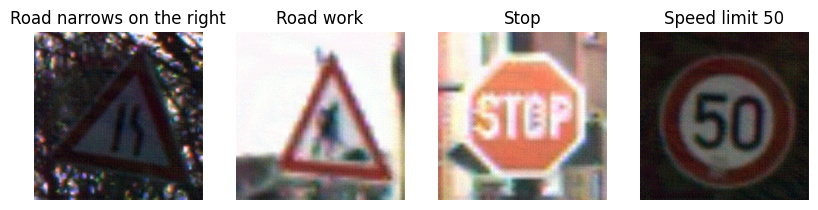

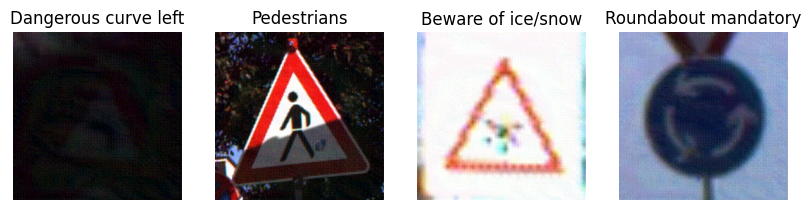

In [98]:
import matplotlib.pyplot as plt

def display_adv_images(dataset, class_mapping, num_images=4):
    plt.figure(figsize=(10, 10))
    count = 0

    for batch_images, batch_labels in dataset:
        for img, label in zip(batch_images.numpy(), batch_labels.numpy()):
            if count >= num_images:
                break
            plt.subplot(1, num_images, count + 1)
            plt.imshow(img.astype('uint8'))
            plt.title(class_mapping[label] if isinstance(class_mapping, dict) else class_mapping[label])
            plt.axis('off')
            count += 1
        if count >= num_images:
            break
    plt.show()

# Call this with your adv_dataset and class_mapping:
print("some adversarial images:")
display_adv_images(adv_dataset, GTSRB_CLASSES, num_images=4)
display_adv_images(adv_dataset, GTSRB_CLASSES, num_images=4)
display_adv_images(adv_dataset, GTSRB_CLASSES, num_images=4)



comparison of clean vs. adversarial evaluation metrics:

| Metric                     | Original | Adversarial |
|----------------------------|----------|-------------|
| **Accuracy**               | 0.96     | 0.34        |
| **Macro Avg Precision**    | 0.97     | 0.73        |
| **Macro Avg Recall**       | 0.96     | 0.34        |
| **Macro Avg F1‑Score**     | 0.96     | 0.42        |
| **Weighted Avg Precision** | 0.97     | 0.73        |
| **Weighted Avg Recall**    | 0.96     | 0.34        |
| **Weighted Avg F1‑Score**  | 0.96     | 0.42        |
| **Support (samples)**      | 516      | 516         |

This shows the drop from ~96% to ~34% accuracy, and corresponding collapses in recall and F1 under the universal perturbation attack.